In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import mne

In [2]:
df = pd.read_csv('./dogos-quest-main/quest_eeg/060924-1700/Explore_84CF_ExG_ExG_stream_3.csv')
ts = np.array(df["Timestamps"])

##Assuming the channels are in the order Fz, Cz, T3, T4, P3, P4, Fp1, Fp2
fz = np.array(df["Ch_1"])
t3 = np.array(df["Ch_3"])
t4 = np.array(df["Ch_4"])
p3 = np.array(df["Ch_5"])
p4 = np.array(df["Ch_6"])

raw_np = np.array([fz,t3,t4,p3,p4])
ch_names = ['Fz','T3','T4','P3','P4']

In [3]:
sfreq = 1000  # Sampling frequency
info = mne.create_info(ch_names,ch_types=['eeg']*len(ch_names),sfreq=sfreq)
raw = mne.io.RawArray(raw_np/1000,info) #mne stores data in volts
raw = raw.resample(sfreq=250)

Creating RawArray with float64 data, n_channels=5, n_times=366512
    Range : 0 ... 366511 =      0.000 ...   366.511 secs
Ready.


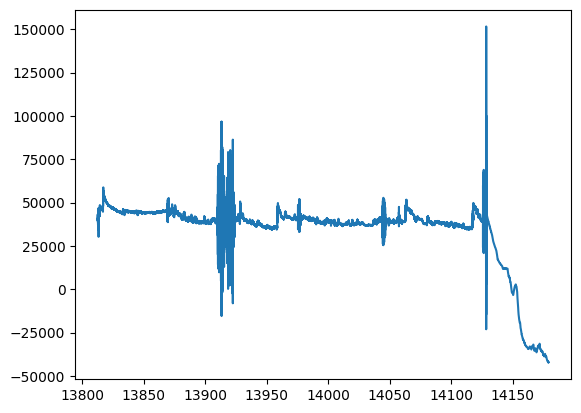

In [4]:
raw.ch_names
plt.plot(ts,t4)

Effective window size : 1.024 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


/tmp/ipykernel_169328/2880641008.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.compute_psd(picks='P3',).plot()
/home/decision_lab/.local/lib/python3.8/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


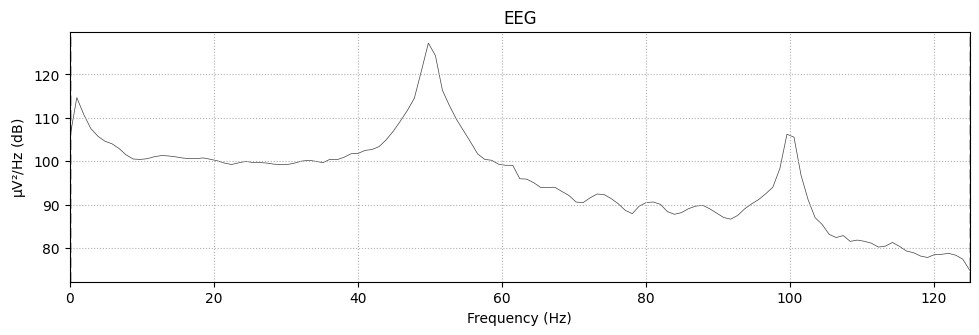

In [14]:
raw.compute_psd(picks='P3',).plot()

In [6]:
mrk = pd.read_csv('./dogos-quest-main/quest_eeg/060924-1700/Explore_84CF_Marker_Markers_stream_1.csv')
num_events = len(mrk)
mrk

,Timestamps,Ch_1
0,13831.980430,sw_1
1,13912.400230,sw_1
2,13944.171259,sw_1
3,13967.001443,sw_1
4,13991.985769,sw_1
5,14008.675637,sw_1
6,14021.595152,sw_1


In [13]:
annot = mne.Annotations(
    onset=mrk["Timestamps"].to_list(),  # in seconds
    duration=[5]*num_events,
    description=mrk["Ch_1"].to_list())

# print(annot.onset)

for idx,onset in enumerate(annot.onset):
    annot.onset[idx] = ts[np.where(ts-onset<0)[0][-1]]

raw.set_annotations(annot)
raw.annotations

# idx = np.where(np.floor(annot.onset[0])==np.floor(ts))[0][0]
# ts[idx+980]
# annot.onset[0]

# ts[19506]-annot.onset[0]
# ts[np.where(ts-annot.onset[1]<0)[0][-1]]


[13831.98042983 13912.40022962 13944.17125893 13967.00144251
 13991.98576928 14008.67563728 14021.59515157]
[13831.98003219 13912.39954416 13944.17035136 13967.00121281
 13991.9850612  14008.67495991 14021.59488151]


/tmp/ipykernel_169328/3473840328.py:13: RuntimeWarning: Omitted 7 annotation(s) that were outside data range.
  raw.set_annotations(annot)


<Annotations | 0 segments>